In [1]:
import random
import itertools

import chat as chat
import data as data
import utility as util

In [2]:
# Import our data -- the load_challenge_moves_csv function also processes the csv load so move / win probability are lists rather than strings
train_df = data.loader.load_challenge_moves_csv("data/chess_challenges_train_10k.csv", shuffle=True)
# print(train_df.info())
# train_df.head(2)

train_iterator = itertools.cycle(train_df.iterrows())

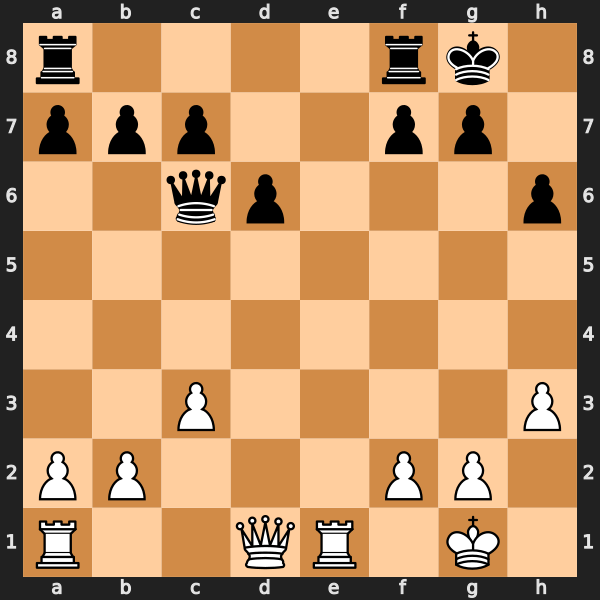

|   Move   |  Win Prob  |
-------------------------
|   f8e8   |   0.6372   |
|   a8e8   |   0.6364   |
|   a7a5   |   0.6364   |
|   a7a6   |   0.6330   |
|   a8d8   |   0.6313   |
|   b7b6   |   0.6287   |
|   a8b8   |   0.6174   |
|   f8c8   |   0.6148   |
|   f8b8   |   0.6148   |
|   f8d8   |   0.6139   |
|   a8c8   |   0.6139   |
|   c6b6   |   0.6105   |
|   g7g6   |   0.6008   |
|   c6d7   |   0.5812   |
|   g8h7   |   0.5776   |
|   b7b5   |   0.5740   |
|   g8h8   |   0.5731   |
|   d6d5   |   0.5722   |
|   c6c5   |   0.5577   |
|   c6b5   |   0.5577   |
|   c6a6   |   0.5541   |
|   g7g5   |   0.5422   |
|   f7f5   |   0.5413   |
|   c6c4   |   0.5175   |
|   f7f6   |   0.5175   |
|   h6h5   |   0.5037   |
|   c6e8   |   0.1322   |
|   c6g2   |   0.1026   |
|   c6e4   |   0.0976   |
|   c6c3   |   0.0947   |
|   c6a4   |   0.0913   |
|   c6d5   |   0.0895   |
|   c6f3   |   0.0880   |

--------------------------------------------------------------------------------
FEN:
r4r

In [3]:
# Can use this to view the data / win probs
_, row = next(train_iterator)
util.visualize_board_ipynb(row["FEN"], size=600)
util.print_top_moves(row["Move"], row["Win Probability"], top_n=None)
legal_moves = row["Move"]
random.shuffle(legal_moves)
print(f"\n{'-'*80}\nFEN:\n{row['FEN']}\nLegal Moves:\n{row['Move']}\n{'-'*80}")

In [11]:
import numpy as np
from scipy import stats

"""
There are two reward functions implemented here:
The first one is reward_zscore, which normalizes the win probabilities using z-scores into the range [0,1],
and returns these normalized values as the rewards. 
This has the benefit of every legal move getting some positive reward,
but comes at the drawback of bad moves still getting some reward.

The second one is reward_clipped, which is a little more complex but does a much better job of distinguishing between good and bad moves.
It first normalizes the win probabilities using z-scores as before, but then sets all moves with a normalized reward below CLIPPING_THRESHOLD to 0.
It then renormalizes the remaining rewards to the range [0,1] and returns these as the rewards.
This has the benefit of only "good" moves getting a reward, but comes at the possible expense of the model getting more infrequent feedback.


I have also included versions that take in a "model_output" parameter, and if the "model_output" is a legal move, it will return the reward for that move.
If it is not a legal move, it will return BAD_OUTPUT_REWARD (intialized to -1) as the reward.

I made these as I wasn't sure how we want the rewards calculated

These second versions call the original versions, so make sure to import correctly if you use them.
"""
CLIPPING_THRESHOLD = 0.5
BAD_OUTPUT_REWARD = -1



def reward_clipped(legal_moves, win_probabilities):
    z_scores = stats.zscore(win_probabilities)
    rewards = clipped_normalize_rewards(z_scores, CLIPPING_THRESHOLD)
    return dict(zip(legal_moves, rewards))

def reward_zscore(legal_moves, win_probabilities):
    z_scores = stats.zscore(win_probabilities)
    return dict(zip(legal_moves, normalize_rewards(z_scores)))

def reward_clipped_with_model_output(legal_moves, win_probabilities, model_output):
    if model_output in legal_moves:
        return reward_clipped(legal_moves, win_probabilities)[legal_moves.index(model_output)]
    return BAD_OUTPUT_REWARD

def reward_zscore_with_model_output(legal_moves, win_probabilities, model_output):
    if model_output in legal_moves:
        return reward_zscore(legal_moves, win_probabilities)[legal_moves.index(model_output)]
    return BAD_OUTPUT_REWARD


def normalize_rewards(z_scores):
    z_min = np.min(z_scores)
    z_max = np.max(z_scores)
    if z_min == z_max:
        return [1]
    return (z_scores - z_min) / (z_max - z_min)


def clipped_normalize_rewards(z_scores, threshold=0.5):
    z_scores = np.array(z_scores, dtype=float)

    # Step 1: Normalize to range [0, 1]
    z_min = np.min(z_scores)
    z_max = np.max(z_scores)
    
    if np.isclose(z_min, z_max):  # Avoid division by zero
        return np.zeros_like(z_scores)

    normalized = (z_scores - z_min) / (z_max - z_min)

    # Step 2: Apply threshold (set values < threshold to 0)
    normalized[normalized < threshold] = 0

    # Step 3: Renormalize to [0, 1] if necessary
    new_min = np.min(normalized)
    new_max = np.max(normalized)

    if np.isclose(new_min, new_max):  # If all remaining values are the same, return as is
        return np.zeros_like(normalized) if new_max == 0 else np.ones_like(normalized)

    return (normalized - new_min) / (new_max - new_min)

_, row = next(train_iterator)
legal_moves = row["Move"]
win_probabilities = row["Win Probability"]
print("Clipped", reward_clipped(legal_moves, win_probabilities))
print("zscore", reward_zscore(legal_moves, win_probabilities))
print("Win probs", win_probabilities)
print("Legal moves", legal_moves)


Clipped {'f8c5': 1.0, 'e6f5': 0.0, 'e6g4': 0.0, 'e6d5': 0.0, 'e6f7': 0.0, 'e6h3': 0.0, 'd8d2': 0.0, 'e6c4': 0.0, 'e6d7': 0.0, 'd8d6': 0.0, 'd8e8': 0.0, 'g8h6': 0.0, 'e6b3': 0.0, 'g7g6': 0.0, 'g8e7': 0.0, 'g7g5': 0.0, 'd8d7': 0.0, 'b7b5': 0.0, 'f8d6': 0.0, 'h7h5': 0.0, 'a6a5': 0.0, 'f6f5': 0.0, 'c8b8': 0.0, 'd8d3': 0.0, 'd8d4': 0.0, 'd8d5': 0.0, 'h7h6': 0.0, 'f8e7': 0.0, 'c8c7': 0.0, 'b7b6': 0.0}
zscore {'f8c5': 1.0, 'e6f5': 0.21607465411070031, 'e6g4': 0.2130905036695048, 'e6d5': 0.19856062633899618, 'e6f7': 0.18196250742253187, 'e6h3': 0.17839476117421943, 'd8d2': 0.16794813981631235, 'e6c4': 0.14817391933886292, 'e6d7': 0.13503196953208446, 'd8d6': 0.12982082531045103, 'd8e8': 0.11833352666072441, 'g8h6': 0.06844019508216277, 'e6b3': 0.06210945207945915, 'g7g6': 0.05162031245480909, 'g8e7': 0.03961468938181884, 'g7g5': 0.03873396543197118, 'd8d7': 0.03569787777561108, 'b7b5': 0.03399498113808379, 'f8d6': 0.032732868517942895, 'h7h5': 0.031898565383676955, 'a6a5': 0.029429377103784245

In [4]:
def evaluate_chess_model(ollama_session, train_iterator, board_representation, max_iters=None, max_timeout=30, verbose=False):
    evaluation_results = {
        "num_attempts": 0,
        "legal_move_ranks": [],
        "num_legal_moves": 0,
        "error_illegal_move": 0,
        "error_timeout": 0,
        "error_generation": 0,
        "error_extraction": 0,
    }
    
    for iter in range(max_iters):
        evaluation_results["num_attempts"] += 1
        try:
            _, row = next(train_iterator)
            prompt = chat.format_prompt(row["FEN"], row["Move"], board_representation)

            # Ensure our moves are sorted by win probability
            sorted_moves_probs = sorted(zip(row["Move"], row["Win Probability"]), key=lambda x: x[1], reverse=True)
            legal_moves, win_probs = zip(*sorted_moves_probs)
            
            # Generate a response from the model
            response, runtime_results = ollama_session.chat(user_prompt=prompt, timeout=max_timeout)
            
            if verbose:
                print(f"{'-'*100}\nPrompt:\n{prompt}\n\nResponse:\n{response}\n\nRuntime Results:\n{runtime_results}\n{'-'*100}\n")
                util.visualize_board_ipynb(row["FEN"])

            move = chat.extract_answer(response)
            if move not in legal_moves:
                raise chat.IllegalMoveError(f"Model predicted illegal move: {move}")

            # If move in legal moves print probability / move ranking
            evaluation_results["num_legal_moves"] += 1
            move_idx = legal_moves.index(move)
            win_prob = win_probs[move_idx]
            move_rank = f"{move_idx+1}/{len(legal_moves)}"
            tps = runtime_results["generated_tokens"] / runtime_results["generation_duration"]
            print(f"[{iter+1:<4}/{max_iters:<4}] Move: {move} | Win Prob: {win_prob:.4f} | Move Rank: {move_rank:<5} | TPS: {tps:.2f}")
            evaluation_results['legal_move_ranks'].append((move_idx+1)/len(legal_moves))
            
        except Exception as e:
            print(f"[{iter+1:<4}/{max_iters:<4}] {type(e).__name__}: {e}")
            if type(e) == chat.IllegalMoveError:
                evaluation_results["error_illegal_move"] += 1
            elif type(e) == chat.TimeoutError:
                evaluation_results["error_timeout"] += 1
            elif type(e) == chat.GenerationError:
                evaluation_results["error_generation"] += 1
            elif type(e) == chat.ExtractionError:
                evaluation_results["error_extraction"] += 1
            else:
                print(f"Unknown Error: {e}")

    # At end print out results
    avg_rank = sum(evaluation_results['legal_move_ranks'])/len(evaluation_results['legal_move_ranks']) if len(evaluation_results['legal_move_ranks']) else 0
    print(f"\n{'='*60}\nAverage Legal Move Score (Rank / Total Moves):\n{avg_rank:.4f}\n")
    print(f"Evaluation Results:\n")
    for key, value in evaluation_results.items():
        if key != "legal_move_ranks":
            print(f"{key}: {value}")

----------------------------------------------------------------------------------------------------
Prompt:
<board> 
White to move.
Black King on g7.
Black Knight on e7.
Black Pawns on b5, c5.
Black Rook on c2.
White Bishop on f5.
White King on g1.
White Pawns on e6, g3, h2.
White Rook on h8. </board> 
 <legalmoves> [g1f1, f5e4, h8h7, f5d3, f5h7, h8f8, h8h6, f5g6, g3g4, h8d8, f5c2, f5h3, h8b8, h8h4, h2h4, h8c8, h8a8, g1h1, h2h3, f5g4, h8e8, h8h5, h8h3, h8g8] </legalmoves>

Response:
<think>
Okay, so I'm playing white and my black king is on g7. My knight is on e7, which might be a risky move for me because it can take the king if moved too far. The pawns are on b5, c5, h2, and there's a rook on c2. On my side, I have a bishop on f5, king on g1, and some white pieces like a rook on h8, but I'm not sure what else is in play.

First, let me see where the pawns are. White pawns on b5 and c5, which means they can move towards e6 or forward to their side's squares. The black pawn on h2 is s

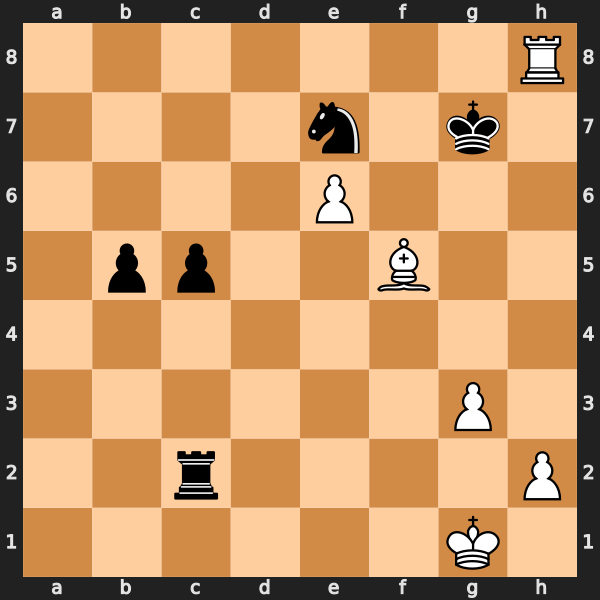

[1   /5   ] Move: h8h7 | Win Prob: 0.5129 | Move Rank: 3/24  | TPS: 28.18
----------------------------------------------------------------------------------------------------
Prompt:
<board> 
Black to move.
Black King on g8.
Black Knight on e4.
Black Pawns on a7, f7, h7, c6, e6, g6, d5.
Black Queen on d6.
Black Rooks on c8, b2.
White King on g1.
White Knight on e5.
White Pawns on d4, f4, g3, a2, c2, h2.
White Queen on h4.
White Rooks on a1, f1. </board> 
 <legalmoves> [d6c7, b2b3, b2b6, e4f6, g6g5, d6b8, e4g3, b2b8, a7a5, c8c7, f7f5, g8h8, h7h6, c8d8, c8a8, b2b4, h7h5, g8g7, c8b8, b2b5, d6e7, d6e5, d6d8, b2b7, e4c3, g8f8, d6f8, c8f8, a7a6, d6b4, c8e8, c6c5, f7f6, b2b1, d6a3, b2c2, d6c5, e4d2, e4f2, b2a2, e4c5, e4g5, d6d7] </legalmoves>

Response:
<think>
Alright, let's break down what the user is asking for and how I should respond. The chess board shows a black knight on e4, pawns scattered across ranks and files, and a white king on g1. White has a knight on e5 and a rook on h8 to ma

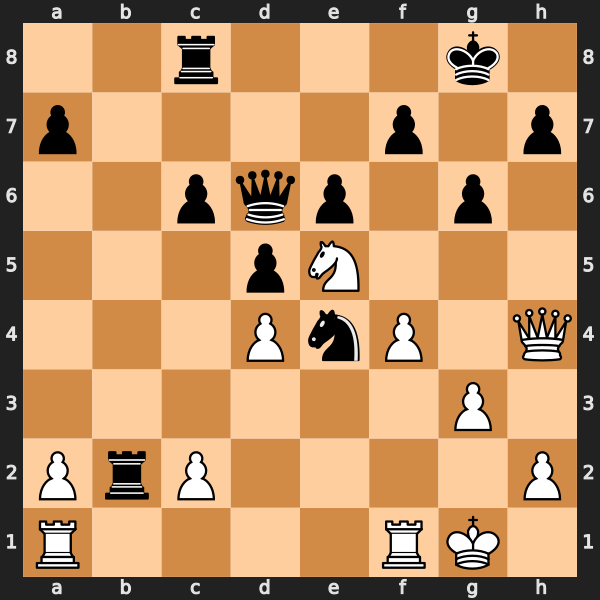

[2   /5   ] IllegalMoveError: Model predicted illegal move: h8h7
----------------------------------------------------------------------------------------------------
Prompt:
<board> 
White to move.
Black Bishop on d7.
Black King on d8.
Black Knight on b6.
Black Pawns on a7, h7, c6, g6, c5.
Black Rook on e8.
White Bishops on h8, b3.
White King on g1.
White Pawns on e5, e4, a3, c3, b2, g2, h2.
White Rook on f7. </board> 
 <legalmoves> [f7e7, g1h1, h8g7, f7f5, a3a4, g2g3, e5e6, b3d1, g2g4, f7d7, b3a2, f7g7, b3c4, b3e6, h8f6, b3a4, g1f2, g1f1, f7f8, f7h7, f7f6, f7f4, h2h4, c3c4, f7f3, f7f1, b3d5, h2h3, f7f2, b3c2] </legalmoves>

Response:
<think>
Alright, so I'm trying to figure out the best move for white in this chess scenario. Let's break down what we have here.

First off, it looks like black has a lot of pieces. There's a bishop on d7, a king on d8, and knights on b6 and h7. The pawns are also positioned quite densely, which suggests that black is trying to control the center quickly.

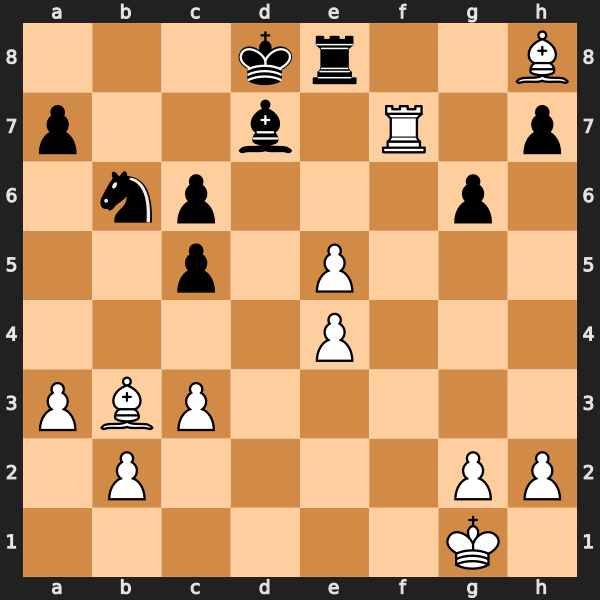

[3   /5   ] Move: f7f6 | Win Prob: 0.2819 | Move Rank: 21/30 | TPS: 27.00
----------------------------------------------------------------------------------------------------
Prompt:
<board> 
Black to move.
Black King on c8.
Black Knights on e8, d7.
Black Pawns on a7, b7, e6, g6, d5.
Black Queen on a5.
Black Rook on d8.
White Bishops on d3, g3.
White King on d2.
White Pawns on g5, c3, a2, c2, f2.
White Queen on f7.
White Rook on h7. </board> 
 <legalmoves> [e8g7, b7b5, a5a2, e8c7, a5c7, a5b4, e8d6, a5c5, e8f6, a5b6, b7b6, a7a6, d5d4, d7b6, d7e5, a5c3, a5a6, d7f6, d7c5, a5a4, d7b8, e6e5, a5b5, d7f8, a5a3] </legalmoves>

Response:
<think>
Alright, let's take a look at this chess problem. So, Black has the King on c8 and has two knights on e8 and d7, along with some pawns and other pieces that I can see are set up pretty strongly. White is trying to move first, but there's an opening that seems familiar.

First off, the presence of two rooks on d8 and g3 gives Black a lot of space to work

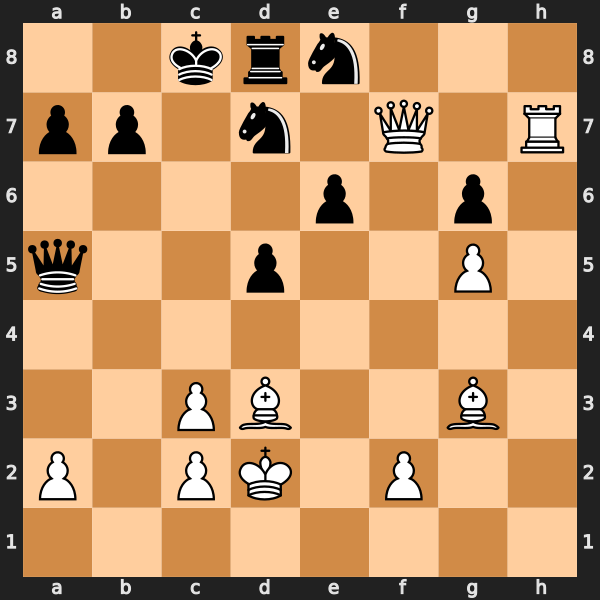

[4   /5   ] Move: e8d6 | Win Prob: 0.1657 | Move Rank: 7/25  | TPS: 27.69
----------------------------------------------------------------------------------------------------
Prompt:
<board> 
Black to move.
Black Bishops on c8, f8.
Black King on e8.
Black Knight on b8.
Black Pawns on a7, b7, c7, f7, g7, f6, h6, c4.
Black Queen on d8.
Black Rooks on a8, h8.
White Bishop on f1.
White King on e1.
White Knights on c3, g1.
White Pawns on d4, e4, a2, b2, f2, g2, h2.
White Queen on d1.
White Rooks on a1, h1. </board> 
 <legalmoves> [f8c5, c7c6, f8a3, e8e7, f8b4, d8d6, c8d7, a7a6, f8d6, h8g8, g7g6, c7c5, a7a5, d8d7, c8h3, c8e6, b8a6, f6f5, b8d7, d8d5, h6h5, d8d4, b7b6, b8c6, e8d7, c8g4, g7g5, h8h7, d8e7, b7b5, c8f5, f8e7] </legalmoves>

Response:
<think>
Alright, I'm trying to figure out the best move for black on this board. Let me take a look at what's available.

First off, it seems like both sides have some pieces that could be useful. Black has two bishops on c8 and f8, which are pretty s

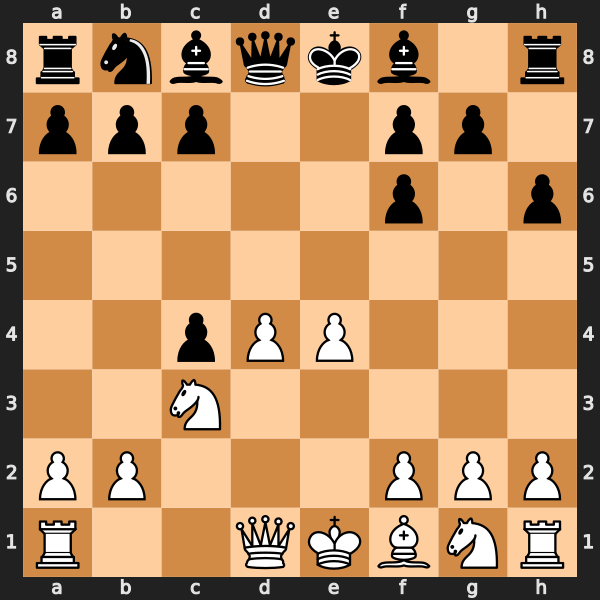

[5   /5   ] Move: f8c5 | Win Prob: 0.5532 | Move Rank: 1/32  | TPS: 23.85

Average Legal Move Score (Rank / Total Moves):
0.2841

Evaluation Results:

num_attempts: 5
num_legal_moves: 4
error_illegal_move: 1
error_timeout: 0
error_generation: 0
error_extraction: 0


In [5]:
# Create a new Ollama Session to allow us to chat w/ various models
# IMPORTANT: Make sure to call `ollama serve` in your terminal to start the Ollama server
# [Lucas]: I'm personally getting ~70TPS on 1.5b and ~7TPS on 7b on my laptop. Most responses are between 1000-2000 tokens.
model_name = "erwan2/DeepSeek-R1-Distill-Qwen-1.5B"       # {deepseek-r1:1.5b, deepseek-r1:7b}
board_rep = "desc" # {grid, desc, FEN}
ollama_session = chat.OllamaSession(model=model_name, use_cuda=False, board_representation= board_rep)

evaluate_chess_model(
    ollama_session = ollama_session, 
    train_iterator = train_iterator, 
    board_representation = board_rep,
    max_iters = 5,
    max_timeout = 200,
    verbose = True
)